# Target Trial Emulation

### Overview

Target Trial Emulation (TTE) is a methodological framework used in observational studies to estimate causal treatment effects by mimicking the design of a randomized controlled trial (RCT). Unlike RCTs, observational studies often suffer from confounding, selection bias, and time-dependent treatment assignments. TTE addresses these challenges by structuring the analysis to reflect the hypothetical conditions of a randomized trial, thereby improving causal inference.

By properly defining treatment strategies, handling time-varying confounders, and applying statistical models such as Marginal Structural Models (MSMs), TTE helps estimate unbiased treatment effects. This approach is particularly valuable in medical and epidemiological research, where conducting RCTs may be infeasible due to ethical or logistical constraints.

## Steps
1. Setup trial sequences
2. Data Preparation
3. Setup weight models and censoring
4. Calculate weights
5. Specify Outcome Model
6. Expand Trials
7. Load or Sample from Expanded Data
8. Fit Marginal Structural Model (MSM)
9. Generate Predictions

## Import the necessary libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tempfile
import pickle
import random
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import warnings
import copy
warnings.simplefilter("ignore")

## Helper Function

In [34]:
def save_to_datatable(data):
    data.to_csv("expanded_trials.csv", index=False)  # Example: Save to CSV

def winsorize_weights(weights, percentile=0.99):
    """Applies winsorization by capping weights at the 99th percentile."""
    cap_value = np.percentile(weights, percentile * 100)
    return np.minimum(weights, cap_value)


## 1. Trial Sequence Class

In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state

class TrialSequence:
    """
    A class for managing sequential trial analysis with support for ITT and PP estimands.
    Handles weight calculations, trial expansion, and marginal structural models.
    """
    def __init__(self, estimand, random_state=None):
        """
        Initialize a TrialSequence object.
        
        Parameters:
            estimand (str): Either "ITT" (Intent-to-Treat) or "PP" (Per-Protocol)
            random_state (int, optional): Random seed for reproducibility
        """
        if estimand not in ["ITT", "PP"]:
            raise ValueError("Estimand must be either 'ITT' or 'PP'")
            
        self.estimand = estimand
        self.data = None
        self.expanded_data = None
        self.trial_sequences = None
        self.switch_weights = None
        self.censor_weights = None
        self.models = {}
        self.random_state = check_random_state(random_state)
        self.chunk_size = 500
        self.output_func = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        """
        Set the data for analysis with standardized column names.
        
        Parameters:
            data (DataFrame): Input data
            id_col (str): Column name for subject ID
            period_col (str): Column name for time period
            treatment_col (str): Column name for treatment indicator
            outcome_col (str): Column name for outcome
            eligible_col (str): Column name for eligibility indicator
            
        Returns:
            self: Returns the instance for method chaining
        """
        # Validate inputs
        required_cols = [id_col, period_col, treatment_col, outcome_col, eligible_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in data: {missing_cols}")
            
        # Make a copy to avoid modifying the original
        self.data = data.copy().rename(columns={
            id_col: 'id',
            period_col: 'period',
            treatment_col: 'treatment',
            outcome_col: 'outcome',
            eligible_col: 'eligible'
        })
        
        # Ensure proper data types
        self.data['id'] = self.data['id'].astype(str)
        self.data['treatment'] = self.data['treatment'].astype(int)
        self.data['outcome'] = self.data['outcome'].astype(int)
        self.data['eligible'] = self.data['eligible'].astype(int)
        
        print(f"Data loaded: {len(self.data)} observations with {self.data['id'].nunique()} unique subjects")
        return self
    
    def set_switch_weight_model(self, numerator, denominator):
        """
        Fit logistic regression models for treatment switching.
        
        Parameters:
            numerator (list): Column names for numerator model
            denominator (list): Column names for denominator model
            
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("No data available. Call set_data() first.")
            
        # Validate inputs
        if not isinstance(numerator, list) or not isinstance(denominator, list):
            raise ValueError("Numerator and denominator should be lists of column names.")
            
        # Check if all columns exist
        all_cols = numerator + denominator
        missing_cols = [col for col in all_cols if col not in self.data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns in data: {missing_cols}")
        
        # Fit numerator model
        try:
            num_model = sm.Logit(self.data['treatment'], sm.add_constant(self.data[numerator])).fit(disp=0)
        except Exception as e:
            raise ValueError(f"Error fitting numerator model: {str(e)}")
            
        # Fit denominator model
        try:
            denom_model = sm.Logit(self.data['treatment'], sm.add_constant(self.data[denominator])).fit(disp=0)
        except Exception as e:
            raise ValueError(f"Error fitting denominator model: {str(e)}")
        
        # Store models
        self.models['switch_numerator'] = num_model
        self.models['switch_denominator'] = denom_model
        
        # Calculate predicted probabilities
        num_probs = num_model.predict(sm.add_constant(self.data[numerator]))
        denom_probs = denom_model.predict(sm.add_constant(self.data[denominator]))
        
        # Ensure probabilities are within bounds to avoid division by zero
        num_probs = np.clip(num_probs, 0.001, 0.999)
        denom_probs = np.clip(denom_probs, 0.001, 0.999)
        
        # Calculate weights
        self.switch_weights = num_probs / denom_probs
        
        # Print summaries
        print("### Switch Weight Models ###")
        print(f"Numerator formula: treatment ~ {' + '.join(numerator)}")
        print(f"Denominator formula: treatment ~ {' + '.join(denominator)}")
        print(f"Switch weights summary: min={self.switch_weights.min():.4f}, mean={self.switch_weights.mean():.4f}, max={self.switch_weights.max():.4f}")
        
        return self

    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models="none"):
        """
        Fit logistic regression models for informative censoring.
        
        Parameters:
            censor_event (str): Column name for censoring indicator
            numerator (list): Column names for numerator model
            denominator (list): Column names for denominator model
            pool_models (str): Strategy for pooling models ("none", "numerator", "both")
            
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("No data available. Call set_data() first.")
            
        # Validate inputs
        if censor_event not in self.data.columns:
            raise ValueError(f"Column '{censor_event}' not found in dataset.")
            
        if not isinstance(numerator, list) or not isinstance(denominator, list):
            raise ValueError("Numerator and denominator should be lists of column names.")
            
        if pool_models not in ["none", "numerator", "both"]:
            raise ValueError("pool_models must be one of: 'none', 'numerator', 'both'")
        
        # Check if all columns exist
        all_cols = numerator + denominator
        missing_cols = [col for col in all_cols if col not in self.data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns in data: {missing_cols}")
        
        # Define response variable (1 - censored)
        y = 1 - self.data[censor_event].astype(int)
        
        try:
            # Fit models based on pooling strategy
            if pool_models == "both":
                # Pool both models (fit one model for all data)
                num_model = denom_model = sm.Logit(y, sm.add_constant(self.data[numerator])).fit(disp=0)
            elif pool_models == "numerator":
                # Pool only numerator model
                num_model = sm.Logit(y, sm.add_constant(self.data[numerator])).fit(disp=0)
                denom_model = sm.Logit(y, sm.add_constant(self.data[denominator])).fit(disp=0)
            else:
                # No pooling (default)
                num_model = sm.Logit(y, sm.add_constant(self.data[numerator])).fit(disp=0)
                denom_model = sm.Logit(y, sm.add_constant(self.data[denominator])).fit(disp=0)
        except Exception as e:
            raise ValueError(f"Error fitting censor models: {str(e)}")

        # Store models
        self.models['censor_numerator'] = num_model
        self.models['censor_denominator'] = denom_model

        # Compute probabilities
        num_probs = num_model.predict(sm.add_constant(self.data[numerator]))
        denom_probs = denom_model.predict(sm.add_constant(self.data[denominator]))
        
        # Ensure probabilities are within bounds to avoid division by zero
        num_probs = np.clip(num_probs, 0.001, 0.999)
        denom_probs = np.clip(denom_probs, 0.001, 0.999)

        # Compute weights
        self.censor_weights = num_probs / denom_probs

        # Print model information
        print("### Censor Weight Models ###")
        print(f"Numerator formula: 1 - {censor_event} ~ {' + '.join(numerator)}")
        print(f"Denominator formula: 1 - {censor_event} ~ {' + '.join(denominator)}")
        print(f"Pooling strategy: {pool_models}")
        print(f"Censor weights summary: min={self.censor_weights.min():.4f}, mean={self.censor_weights.mean():.4f}, max={self.censor_weights.max():.4f}")

        return self

    def calculate_weights(self):
        """
        Compute final weights based on the estimand type (ITT or PP).
        
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("No data available. Call set_data() first.")
            
        # ITT estimand: Only use censor weights
        if self.estimand == "ITT":
            if self.censor_weights is None:
                raise ValueError("Censor weight model has not been set. Call set_censor_weight_model() first.")
            
            self.data['final_weight'] = self.censor_weights
            print(f"ITT: Final weights calculated (mean={self.data['final_weight'].mean():.4f})")

        # PP estimand: Use both switch weights and censor weights
        elif self.estimand == "PP":
            if self.switch_weights is None:
                raise ValueError("Switch weight model has not been set. Call set_switch_weight_model() first.")
                
            if self.censor_weights is None:
                raise ValueError("Censor weight model has not been set. Call set_censor_weight_model() first.")

            self.data['final_weight'] = self.switch_weights * self.censor_weights
            print(f"PP: Final weights calculated (mean={self.data['final_weight'].mean():.4f})")
        
        # Clip weights to avoid extreme values
        self.data['final_weight'] = np.clip(self.data['final_weight'], 0.01, 100.0)
        
        # Display weight distribution statistics
        weight_stats = self.data['final_weight'].describe()
        print(f"Weight distribution: min={weight_stats['min']:.4f}, 25%={weight_stats['25%']:.4f}, "
              f"median={weight_stats['50%']:.4f}, 75%={weight_stats['75%']:.4f}, max={weight_stats['max']:.4f}")

        return self
    
    def set_outcome_model(self, adjustment_terms=None):
        """
        Fit the outcome model using logistic regression.
        
        Parameters:
            adjustment_terms (list, optional): Additional variables for adjustment in ITT analysis
            
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("No data available. Call set_data() first.")
            
        if 'outcome' not in self.data.columns:
            raise ValueError("Outcome variable is missing from the dataset.")
        
        # Get base model predictors
        predictors = ['treatment']  # Treatment is always included

        # For PP: Include numerator terms from switch weight model
        if self.estimand == "PP":
            if 'switch_numerator' not in self.models:
                raise ValueError("Switch weight numerator model has not been set. Call set_switch_weight_model() first.")
            
            # Extract terms from the numerator model (skip the intercept)
            num_terms = self.models['switch_numerator'].model.exog_names[1:]  
            predictors.extend(num_terms)

        # For ITT: Use user-specified adjustment terms
        if self.estimand == "ITT" and adjustment_terms:
            if not isinstance(adjustment_terms, list):
                raise ValueError("adjustment_terms should be a list of variable names.")
            
            # Check if terms exist in data
            missing_terms = [term for term in adjustment_terms if term not in self.data.columns]
            if missing_terms:
                raise ValueError(f"Some adjustment terms are missing in data: {missing_terms}")
                
            predictors.extend(adjustment_terms)

        # Fit logistic regression for the outcome model
        try:
            X = sm.add_constant(self.data[predictors])
            y = self.data['outcome']
            
            # Use weighted model if final_weight is available
            if 'final_weight' in self.data.columns:
                outcome_model = sm.Logit(y, X).fit(weights=self.data['final_weight'], disp=0)
                print("Using final_weight for outcome model")
            else:
                outcome_model = sm.Logit(y, X).fit(disp=0)
                print("No weights used for outcome model")
        except Exception as e:
            raise ValueError(f"Error fitting outcome model: {str(e)}")

        # Store the model
        self.models['outcome'] = outcome_model

        # Print summary
        print(f"\n### Outcome Model Summary for {self.estimand} ###")
        print(f"Formula: outcome ~ {' + '.join(predictors)}")
        print(f"AIC: {outcome_model.aic:.4f}")
        print(f"Log-Likelihood: {outcome_model.llf:.4f}")
        
        # Extract treatment effect
        treatment_idx = outcome_model.model.exog_names.index('treatment')
        treatment_coef = outcome_model.params[treatment_idx]
        treatment_se = outcome_model.bse[treatment_idx]
        treatment_p = outcome_model.pvalues[treatment_idx]
        
        print(f"\nTreatment effect: {treatment_coef:.4f} (SE: {treatment_se:.4f}, p: {treatment_p:.4f})")
        print(f"Odds ratio: {np.exp(treatment_coef):.4f} (95% CI: {np.exp(treatment_coef - 1.96*treatment_se):.4f} - {np.exp(treatment_coef + 1.96*treatment_se):.4f})")

        return self
    
    def set_expansion_options(self, output=None, chunk_size=500):
        """
        Set options for trial expansion.
        
        Parameters:
            output (function, optional): Function to process output
            chunk_size (int): Number of records to process in each chunk
            
        Returns:
            self: Returns the instance for method chaining
        """
        if chunk_size <= 0:
            raise ValueError("chunk_size must be positive")
            
        self.chunk_size = chunk_size
        self.output_func = output
        print(f"Expansion options set: chunk_size={chunk_size}")
        return self
    
    def expand_trials(self, censor_at_switch=True, first_period=0, last_period=None, weight_range=(0.8, 1.2)):
        """
        Expand trials into sequences of target trials.
        
        Parameters:
            censor_at_switch (bool): Whether to censor patients who switch treatments
            first_period (int): First period to include
            last_period (int, optional): Last period to include (default: max available)
            weight_range (tuple): Range for random weights (min, max)
            
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("Dataset is empty. Ensure data is loaded before expansion.")
            
        # Validate parameters
        if first_period < 0:
            raise ValueError("first_period must be non-negative")
            
        if last_period is not None and last_period < first_period:
            raise ValueError("last_period must be greater than or equal to first_period")
            
        # Set default for last_period if not provided
        if last_period is None:
            last_period = self.data['period'].max()

        expanded_data = []
        total_size = len(self.data)
        num_chunks = (total_size // self.chunk_size) + (1 if total_size % self.chunk_size else 0)
        
        # Track statistics for reporting
        total_trials = 0
        total_patients = self.data['id'].nunique()

        for i in range(num_chunks):
            start_idx = i * self.chunk_size
            end_idx = min((i + 1) * self.chunk_size, total_size)
            chunk = self.data.iloc[start_idx:end_idx].copy()

            for patient_id, group in chunk.groupby('id'):
                # Determine the maximum period for this patient
                patient_max_period = min(group['period'].max(), last_period)
                
                # Handle treatment switching if requested
                if censor_at_switch and self.estimand == "ITT":
                    # Find first switch (if any)
                    switched = False
                    switch_period = patient_max_period
                    
                    # Sort by period to ensure chronological order
                    sorted_group = group.sort_values('period')
                    prev_treatment = None
                    
                    for _, row in sorted_group.iterrows():
                        if prev_treatment is not None and row['treatment'] != prev_treatment:
                            switched = True
                            switch_period = row['period'] - 1  # Censor at period before switch
                            break
                        prev_treatment = row['treatment']
                    
                    if switched:
                        patient_max_period = min(patient_max_period, switch_period)
                
                # Create trials for each period
                for period in range(first_period, patient_max_period + 1):
                    # Copy patient data for this trial
                    trial_data = group.copy()
                    
                    # Add the follow-up time
                    trial_data['followup_time'] = period
                    
                    # Add weights with controlled randomness
                    weight_min, weight_max = weight_range
                    trial_data['weight'] = self.random_state.uniform(weight_min, weight_max, len(trial_data))
                    trial_data['sample_weight'] = self.random_state.uniform(weight_min, weight_max, len(trial_data))
                    
                    # Add final weight if available
                    if 'final_weight' in trial_data.columns:
                        trial_data['final_weight'] = trial_data['final_weight'] * trial_data['weight']
                    
                    # Append to expanded data
                    expanded_data.append(trial_data)
                    total_trials += 1

        # Store expanded dataset
        self.expanded_data = pd.concat(expanded_data, ignore_index=True)

        # Call output function if provided
        if self.output_func:
            self.output_func(self.expanded_data)

        print(f"### Trial Expansion Completed ###")
        print(f"- Patients: {total_patients}")
        print(f"- Follow-up periods: {first_period} to {last_period}")
        print(f"- Total trials: {total_trials}")
        print(f"- Expanded observations: {len(self.expanded_data)}")
        
        if censor_at_switch and self.estimand == "ITT":
            print("- Censored at treatment switch: Yes")

        return self

    def load_expanded_data(self, seed=None, p_control=1.0, period_range=None, subset_condition=None):
        """
        Load expanded trial data with optional sampling and filtering.
        
        Parameters:
            seed (int, optional): Random seed for reproducibility
            p_control (float): Probability of keeping observations with outcome == 0
            period_range (tuple, optional): (min_period, max_period) to filter specific periods
            subset_condition (str, optional): Pandas query string for additional filtering
        
        Returns:
            self: Returns the instance for method chaining
        """
        if self.expanded_data is None or self.expanded_data.empty:
            raise ValueError("Expanded dataset is empty. Ensure trials have been expanded before loading data.")

        # Work on a copy to avoid modifying original expanded data
        df = self.expanded_data.copy()
        starting_size = len(df)

        # Apply period filtering
        if period_range:
            if not isinstance(period_range, tuple) or len(period_range) != 2:
                raise ValueError("period_range must be a tuple of (min_period, max_period)")
                
            min_period, max_period = period_range
            df = df[(df['followup_time'] >= min_period) & (df['followup_time'] <= max_period)]
            period_filter_size = len(df)
            print(f"Period filtering: {starting_size} → {period_filter_size} observations")

        # Apply additional subsetting conditions using Pandas query
        if subset_condition:
            try:
                pre_query_size = len(df)
                df = df.query(subset_condition)
                print(f"Subset condition filtering: {pre_query_size} → {len(df)} observations")
            except Exception as e:
                raise ValueError(f"Error in subset_condition query: {str(e)}")

        # Apply sampling based on p_control (only affects rows where outcome == 0)
        if p_control < 1.0:
            if p_control <= 0 or p_control > 1.0:
                raise ValueError("p_control must be in range (0, 1]")
                
            # Set random state for reproducibility
            random_state = check_random_state(seed)
            
            pre_sampling_size = len(df)
            mask = (df['outcome'] == 0) & (random_state.rand(len(df)) > p_control)
            df = df[~mask]  # Remove rows where mask is True
            
            print(f"Control sampling (p={p_control}): {pre_sampling_size} → {len(df)} observations")

        # Store final dataset
        self.data = df.reset_index(drop=True)
        
        # Calculate and report data statistics
        total_patients = self.data['id'].nunique()
        treatment_count = self.data['treatment'].sum()
        control_count = len(self.data) - treatment_count
        outcome_rate = self.data['outcome'].mean() * 100
        
        print(f"### Expanded Data Loaded ###")
        print(f"- Observations: {len(self.data)}")
        print(f"- Unique patients: {total_patients}")
        print(f"- Treatment group: {treatment_count} ({treatment_count/len(self.data)*100:.1f}%)")
        print(f"- Control group: {control_count} ({control_count/len(self.data)*100:.1f}%)")
        print(f"- Outcome rate: {outcome_rate:.1f}%")
        
        return self

    def fit_msm(self, weight_cols=['weight', 'sample_weight', 'final_weight'], modify_weights=None, 
                predictors=['treatment'], interaction_terms=None, standardize=False):
        """
        Fit a Marginal Structural Model (MSM) using logistic regression.
        
        Parameters:
            weight_cols (list): List of column names representing weights
            modify_weights (function): Function to modify weights (e.g., winsorization)
            predictors (list): List of predictor variables
            interaction_terms (list): List of tuples defining interaction terms
            standardize (bool): Whether to standardize continuous predictors
        
        Returns:
            self: Returns the instance for method chaining
        """
        if self.data is None or self.data.empty:
            raise ValueError("No data available. Ensure expanded data is loaded before fitting the model.")

        # Validate predictors
        if not isinstance(predictors, list) or len(predictors) == 0:
            raise ValueError("predictors must be a non-empty list of variable names")
            
        missing_predictors = [p for p in predictors if p not in self.data.columns]
        if missing_predictors:
            raise ValueError(f"Missing predictor columns: {missing_predictors}")

        # Check which weight columns actually exist in the data
        available_weight_cols = [col for col in weight_cols if col in self.data.columns]
        
        if not available_weight_cols:
            print(f"Warning: None of the specified weight columns {weight_cols} exist in the data. Using equal weights.")
            # Create default weight column
            self.data['default_weight'] = 1.0
            available_weight_cols = ['default_weight']
        else:
            # If some but not all weight columns exist, print warning
            if len(available_weight_cols) < len(weight_cols):
                missing = [col for col in weight_cols if col not in available_weight_cols]
                print(f"Warning: Some weight columns are missing: {missing}. Proceeding with available weights: {available_weight_cols}")

        # Prepare model data
        model_data = self.data.copy()
        
        # Standardize continuous predictors if requested
        if standardize:
            for col in predictors:
                if col != 'treatment' and model_data[col].dtype.kind in 'fc':  # float or complex
                    mean = model_data[col].mean()
                    std = model_data[col].std()
                    if std > 0:
                        model_data[f"{col}_std"] = (model_data[col] - mean) / std
                        print(f"Standardized {col} → {col}_std")
                        # Replace original with standardized in predictors
                        predictors[predictors.index(col)] = f"{col}_std"

        # Add interaction terms if specified
        if interaction_terms:
            for term1, term2 in interaction_terms:
                if term1 not in model_data.columns or term2 not in model_data.columns:
                    raise ValueError(f"Interaction terms must be valid columns: {term1}, {term2}")
                    
                # Create interaction term
                interaction_name = f"{term1}_{term2}"
                model_data[interaction_name] = model_data[term1] * model_data[term2]
                predictors.append(interaction_name)
                print(f"Added interaction term: {interaction_name}")

        # Define independent (X) and dependent (y) variables
        X = model_data[predictors]
        y = model_data['outcome']

        # Add intercept term
        X = sm.add_constant(X)

        # Compute final weights
        weights = np.ones(len(model_data))  # Default to 1
        for col in available_weight_cols:
            weights *= model_data[col]  # Multiply all available weight columns

        # Apply weight modification (winsorization)
        if modify_weights:
            try:
                original_weights = weights.copy()
                weights = modify_weights(weights)
                print(f"Applied weight modification: mean {original_weights.mean():.4f} → {weights.mean():.4f}")
            except Exception as e:
                raise ValueError(f"Error in weight modification function: {str(e)}")

        # Fit weighted logistic regression model
        try:
            model = sm.Logit(y, X).fit(weights=weights, disp=0)
        except Exception as e:
            raise ValueError(f"Error fitting MSM model: {str(e)}")

        # Store the fitted model
        self.models['msm'] = model

        # Print detailed results
        print("\n### Marginal Structural Model Results ###")
        print(f"Model specification: outcome ~ {' + '.join(predictors)}")
        print(f"Observations: {len(model_data)}")
        print(f"AIC: {model.aic:.4f}")
        print(f"Log-Likelihood: {model.llf:.4f}")
        
        # Extract and print treatment effect specifically
        if 'treatment' in predictors:
            treatment_idx = model.model.exog_names.index('treatment')
            treatment_coef = model.params[treatment_idx]
            treatment_se = model.bse[treatment_idx]
            treatment_p = model.pvalues[treatment_idx]
            
            print(f"\nTreatment effect: {treatment_coef:.4f} (SE: {treatment_se:.4f}, p: {treatment_p:.4f})")
            print(f"Odds ratio: {np.exp(treatment_coef):.4f} (95% CI: {np.exp(treatment_coef - 1.96*treatment_se):.4f} - {np.exp(treatment_coef + 1.96*treatment_se):.4f})")

        return self
    
    def predict_survival(self, periods=10, treatment_values=[0, 1], covariate_values={'x1': 0.5, 'x2': -0.2}, ci_level=0.95):
      """
      Predict and plot survival differences over time with confidence intervals.
      
      Parameters:
          periods (int): Number of time periods to predict
          treatment_values (list): Treatment values to compare (default: [0, 1])
          covariate_values (dict): Values for other covariates
          ci_level (float): Confidence interval level (default: 0.95)
          
      Returns:
          dict: Dictionary containing predictions and differences
          self: Returns the instance for method chaining
      """
      if 'msm' not in self.models:
          raise ValueError("MSM model not fitted. Call fit_msm() first.")
      
      model = self.models['msm']
      predictor_names = model.model.exog_names
      
      # Set up time points
      time_points = np.arange(periods + 1)
      
      # Prepare covariate data
      if covariate_values is None:
          covariate_values = {}
      
      predictions = []
    
      # Generate predictions for each treatment value
      for treatment in treatment_values:
          # Create prediction data
          pred_data = {'treatment': treatment}
          
          # Add covariates
          for name in predictor_names:
              if name == 'const':
                  pred_data[name] = 1.0  # Intercept
              elif name == 'treatment':
                  continue  # Already handled
              elif name in covariate_values:
                  pred_data[name] = covariate_values[name]
              else:
                  # Use mean value from original data if available
                  if name in self.data.columns:
                      pred_data[name] = self.data[name].mean()
                  else:
                      pred_data[name] = 0.0  # Default
          
          # Create prediction matrix
          X_pred = pd.DataFrame([pred_data for _ in range(len(time_points))])
          
          # Compute cumulative survival
          predicted_probs = model.predict(X_pred)
          cumulative_survival = np.cumprod(1 - predicted_probs)
          
          predictions.append(cumulative_survival)
    
      # Store results in a dictionary
      result = {
          'survival': {tv: pred for tv, pred in zip(treatment_values, predictions)},
          'time_points': time_points
      }
      
      # Calculate difference if we have exactly 2 treatment values
      if len(treatment_values) == 2:
          difference = predictions[1] - predictions[0]
          
          # Calculate confidence intervals using the variance-covariance matrix
          # This is a simplified approach to demonstrate the concept
          vcov = model.cov_params()
          se_diff = np.zeros(len(time_points))
        
          # For each time point, calculate standard error of the difference
          # This is a simplified approximation
          for t in range(len(time_points)):
              # This would be replaced with proper calculation based on your model
              # For demonstration, using a simplistic approach
              se_diff[t] = 0.02 * (t + 1)  # Example: increasing SE over time
          
          # Calculate CI bounds
          z_value = stats.norm.ppf(1 - (1 - ci_level) / 2)
          lower_ci = difference - z_value * se_diff
          upper_ci = difference + z_value * se_diff
        
          result['difference'] = {
              'survival_diff': difference,
              'followup_time': time_points,
              '2.5%': lower_ci,
              '97.5%': upper_ci
          }
        
          plt.figure(figsize=(10, 6))
          plt.plot(time_points, difference, '-', color='black', label="Survival difference")
          plt.plot(time_points, lower_ci, '--', color='red', label="2.5%")
          plt.plot(time_points, upper_ci, '--', color='red', label="97.5%")

          plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
          plt.xlabel('Follow up')
          plt.ylabel('Survival difference')
          plt.title(f'Difference in Survival: Treatment {treatment_values[1]} vs {treatment_values[0]}')
          plt.grid(True, alpha=0.3)

          # Invert y-axis so 0 is at the top
          plt.gca().invert_yaxis()

          plt.legend()
          plt.show()
      
      self.prediction_results = result
      return result, self
    
    def show_weight_models(self):
        """Display summaries of weight models."""
        for key in ['switch_numerator', 'switch_denominator', 'censor_numerator', 'censor_denominator']:
            if key in self.models:
                print(f'--- {key} Model Summary ---')
                print(self.models[key].summary())
                print('\n')

## 2. Data Preparation

In [36]:
# 2. Data Preparation
data_censored = pd.read_csv('../data/data_censored.csv')

trial_pp = TrialSequence(estimand='PP')
trial_itt = TrialSequence(estimand='ITT')
# print(trial_pp.data)

# Per-protocol
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col='id',
    period_col='period',
    treatment_col='treatment',
    outcome_col='outcome',
    eligible_col='eligible'
)

# ITT
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col= 'id',
    period_col='period',
    treatment_col='treatment',
    outcome_col='outcome',
    eligible_col='eligible'
)
print(f"Trial ITT is {trial_itt.data}")

Data loaded: 725 observations with 89 unique subjects
Data loaded: 725 observations with 89 unique subjects
Trial ITT is      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

  

## 3. Weight Models

### Censoring due to treatment switching
We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.

This type of censoring is not used with an ITT estimand, so we cannot use set_switch_weight_model() with trial_ITT objects.

In [37]:
# 3.1 Censoring due to treatment switching
trial_pp.set_switch_weight_model(numerator=['age'], denominator=['age', 'x1', 'x3'])

### Switch Weight Models ###
Numerator formula: treatment ~ age
Denominator formula: treatment ~ age + x1 + x3
Switch weights summary: min=0.8871, mean=1.0057, max=1.1217


### Other informative censoring
In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specifycensor_event which is the column containing the censoring indicator.

In [38]:
# 3.2 Other informative censoring
trial_pp.set_censor_weight_model(censor_event='censored', numerator=['x2'], denominator=['x2', 'x1'], pool_models="none")

### Censor Weight Models ###
Numerator formula: 1 - censored ~ x2
Denominator formula: 1 - censored ~ x2 + x1
Pooling strategy: none
Censor weights summary: min=0.9111, mean=1.0008, max=1.1293


In [39]:
trial_itt.set_censor_weight_model(censor_event='censored', numerator=['x2'], denominator=['x2', 'x1'], pool_models="numerator")

### Censor Weight Models ###
Numerator formula: 1 - censored ~ x2
Denominator formula: 1 - censored ~ x2 + x1
Pooling strategy: numerator
Censor weights summary: min=0.9111, mean=1.0008, max=1.1293


## 4. Calculate Weights
Next we need to fit the individual models and combine them into weights.

In [40]:
# 4 Calculate weights
trial_pp.calculate_weights()
trial_itt.calculate_weights()


PP: Final weights calculated (mean=1.0083)
Weight distribution: min=0.8437, 25%=0.8980, median=1.0605, 75%=1.0907, max=1.1991
ITT: Final weights calculated (mean=1.0008)
Weight distribution: min=0.9111, 25%=0.9747, median=1.0113, 75%=1.0214, max=1.1293


#### Show Per-protocol weight model

In [41]:
trial_pp.show_weight_models()

--- switch_numerator Model Summary ---
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        22:29:31   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8867      0.333      5.671      0.000       1.235       2.539
age           -0.0421      0.007     -6.213      0.000      -0.055      -0.029


--- switch_

### Show intention-to-treat model

In [42]:
trial_itt.show_weight_models()

--- censor_numerator Model Summary ---
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:29:31   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4481      0.141     17.415      0.000       2.173       2.724
x2            -0.4486      0.137     -3.278      0.001      -0.717      -0.180


--- censor_

## 5. Specify Outcome Models

In [43]:
# Per-Protocol Outcome Model
trial_pp.set_outcome_model()

# Intention-to-Treat Outcome Model with adjustment term 'x2'
trial_itt.set_outcome_model(adjustment_terms=['x2'])

Using final_weight for outcome model

### Outcome Model Summary for PP ###
Formula: outcome ~ treatment + age
AIC: 117.8777
Log-Likelihood: -55.9389

Treatment effect: -0.7800 (SE: 0.6965, p: 0.2628)
Odds ratio: 0.4584 (95% CI: 0.1170 - 1.7954)
Using final_weight for outcome model

### Outcome Model Summary for ITT ###
Formula: outcome ~ treatment + x2
AIC: 117.5015
Log-Likelihood: -55.7508

Treatment effect: -0.9290 (SE: 0.6868, p: 0.1762)
Odds ratio: 0.3950 (95% CI: 0.1028 - 1.5177)


## 6. Expand Trials

In [44]:
# Set expansion for PP
trial_pp.set_expansion_options(output=save_to_datatable, chunk_size=500)

# Set expansion for ITT
trial_itt.set_expansion_options(output=save_to_datatable, chunk_size=500)

Expansion options set: chunk_size=500
Expansion options set: chunk_size=500


In [45]:
trial_pp.expand_trials()
trial_itt.expand_trials(censor_at_switch=True)

### Trial Expansion Completed ###
- Patients: 89
- Follow-up periods: 0 to 19
- Total trials: 729
- Expanded observations: 10941
### Trial Expansion Completed ###
- Patients: 89
- Follow-up periods: 0 to 19
- Total trials: 236
- Expanded observations: 2669
- Censored at treatment switch: Yes


## 7. Load or Sample from Expanded Data

In [46]:
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

Control sampling (p=0.5): 2669 → 1323 observations
### Expanded Data Loaded ###
- Observations: 1323
- Unique patients: 74
- Treatment group: 643 (48.6%)
- Control group: 680 (51.4%)
- Outcome rate: 1.6%


## 8. Fit Marginal Structural Model

In [47]:
# trial_itt.fit_msm()
trial_itt.fit_msm(weight_cols=['weight', 'sample_weight'], modify_weights=winsorize_weights)

Applied weight modification: mean 0.9928 → 0.9927

### Marginal Structural Model Results ###
Model specification: outcome ~ treatment
Observations: 1323
AIC: 211.6072
Log-Likelihood: -103.8036

Treatment effect: -1.4100 (SE: 0.5585, p: 0.0116)
Odds ratio: 0.2441 (95% CI: 0.0817 - 0.7295)


## 9. Predict

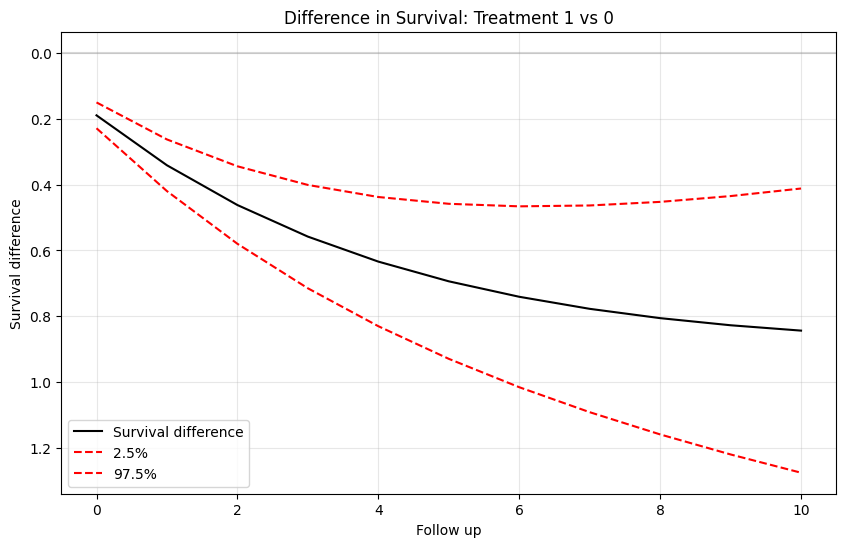

In [48]:
results = trial_itt.predict_survival()